# Differentiating nuclei according to signal intensity
A common bio-image analysis task is differentiating cells according to their signal expression. In this example we take a two-channel image of nuclei which express Cy3 and eGFP. Visually, we can easily see that some nuclei expressing Cy3 also express eGFP, others don't. This notebook demonstrates how to differentiate nuclei segmented in one channel according to the intensity in the other channel.

In [1]:
import pyclesperanto_prototype as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import pandas as pd

cle.get_device()

<Apple M1 Max on Platform: Apple (2 refs)>

We're using a dataset published by [Heriche et al.](https://doi.org/10.1091/mbc.E13-04-0221) licensed [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) available in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/img_detail/179719/).

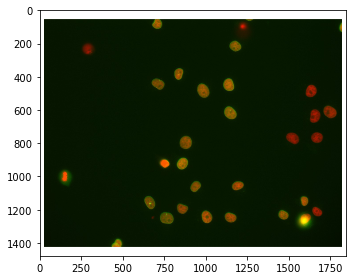

In [2]:
# load file
raw_image = imread('plate1_1_013 [Well 5, Field 1 (Spot 5)].png')

# visualize
imshow(raw_image)

First, we need to split channels ([read more](https://github.com/BiAPoL/Bio-image_Analysis_with_Python/blob/a62070dee408814cee4258758f5187f135774519/image_processing/03_multi_channel_image_data.ipynb)). After that, we can actually see that not all cells marked with Cy3 (channel 0) are also marked with eGFP (channel 1):

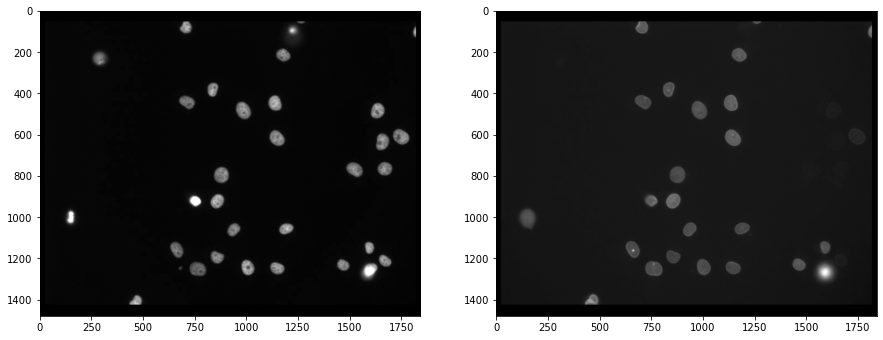

In [3]:
# extract channels
channel_cy3 = raw_image[...,0]
channel_egfp = raw_image[...,1]

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(channel_cy3, cmap='gray')
axs[1].imshow(channel_egfp, cmap='gray')

## Segmenting nuclei
As the staining marks the nuclei in the Cy3 channel, it is reasonable to segment nuclei in this channel and afterwards measure the intensity in the other channel. We use [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/f9c9b73c1f9f194fdabdab8bd8507eb73c3ef8c9/demo/segmentation/voronoi_otsu_labeling.ipynb) for the segmentation because it is a quick and straightforward approach.

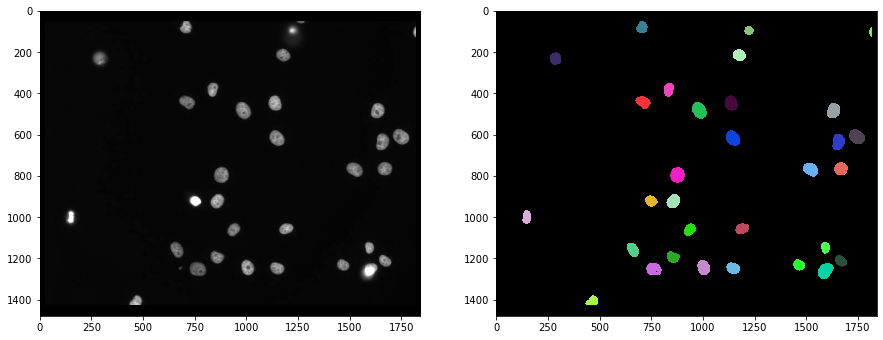

In [4]:
# segmentation
nuclei_cy3 = cle.voronoi_otsu_labeling(channel_cy3, spot_sigma=20)

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
cle.imshow(channel_cy3, plot=axs[0], color_map="gray")
cle.imshow(nuclei_cy3, plot=axs[1], labels=True)

Firstly, we can measure the intensity in the second channel, marked with eGFP and visualize that measurement in a parametric image. In such a parametric image, all pixels inside a nucleus have the same value, in this case the mean average intensity of the cell.

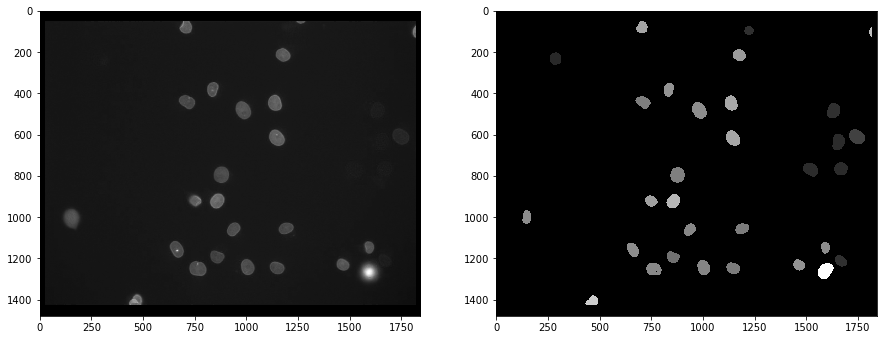

In [5]:
intensity_map = cle.mean_intensity_map(channel_egfp, nuclei_cy3)

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
cle.imshow(channel_egfp, plot=axs[0], color_map="gray")
cle.imshow(intensity_map, plot=axs[1], color_map="gray")

From such a parametric image, we can retrieve the intensity values and get them in a vector. The first item in this list has value 0 and corresponds to the intensity of the background, which is 0 in the parametric image.

In [6]:
intensity_vector = cle.read_intensities_from_map(nuclei_cy3, intensity_map)
intensity_vector

cl.Array([[  0.      ,  80.87585 ,  23.529799, 118.17817 ,  80.73025 ,
         95.55178 ,  72.84752 ,  92.34759 ,  78.84362 ,  85.400444,
        105.108025,  65.06639 ,  73.69295 ,  77.40092 ,  81.48371 ,
         77.12867 ,  96.582085,  95.94536 ,  70.883995,  89.705025,
         72.01046 ,  27.257877,  84.460075,  25.497112,  80.69056 ,
        147.49736 ,  28.112642,  25.16763 ,  28.448261,  25.31705 ,
         38.072815, 108.81613 ]], dtype=float32)

There is by the way also an alternative way to come to the mean intensities directly, by measuring all properties of the nuclei including position and shape. It the statistics can be further processed as [pandas](https://pandas.pydata.org/) DataFrame.

In [7]:
statistics = cle.statistics_of_background_and_labelled_pixels(channel_egfp, nuclei_cy3)

statistics_df = pd.DataFrame(statistics)
statistics_df.head()

,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,centroid_z,sum_distance_to_centroid,mean_distance_to_centroid,sum_distance_to_mass_center,mean_distance_to_mass_center,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio
0,1,0,0.0,0.0,0.0,1841.0,1477.0,0.0,1842.0,1478.0,...,0.0,1.683849e+09,640.648621,1.683884e+09,640.661621,8.487288,1187.033325,1187.743164,1.852862,1.853932
1,2,1,127.0,967.0,0.0,167.0,1033.0,0.0,41.0,67.0,...,0.0,4.128045e+04,18.704329,4.128327e+04,18.705606,4.734930,34.280666,34.338104,1.832767,1.835712
2,3,2,259.0,205.0,0.0,314.0,265.0,0.0,56.0,61.0,...,0.0,5.392080e+04,19.715101,5.393992e+04,19.722090,1.663604,32.079910,31.469477,1.627174,1.595646
3,4,3,432.0,1377.0,0.0,492.0,1423.0,0.0,61.0,47.0,...,0.0,3.630314e+04,17.769527,3.636824e+04,17.801392,24.842558,36.856163,36.085430,2.074122,2.027113
4,5,4,631.0,1123.0,0.0,690.0,1194.0,0.0,60.0,72.0,...,0.0,6.753253e+04,21.686747,6.755171e+04,21.692907,17.358543,38.805695,38.417568,1.789374,1.770974


The intensity vector can then be retrieved from the tabular statistics. Note: In this case, the background intensity is not 0, because we were directly reading it from the original image.

In [8]:
intensity_vector2 = statistics['mean_intensity']
intensity_vector2

array([ 20.829758,  80.87585 ,  23.529799, 118.17817 ,  80.73025 ,
        95.55178 ,  72.84752 ,  92.34759 ,  78.84362 ,  85.400444,
       105.108025,  65.06639 ,  73.69295 ,  77.40092 ,  81.48371 ,
        77.12867 ,  96.582085,  95.94536 ,  70.883995,  89.705025,
        72.01046 ,  27.257877,  84.460075,  25.497112,  80.69056 ,
       147.49736 ,  28.112642,  25.16763 ,  28.448261,  25.31705 ,
        38.072815, 108.81613 ], dtype=float32)

To get an averview about the mean intensity measurement, we can use [matplotlib](https://matplotlib.org/) to plot a histogram. We ignore the first element, because it corresponds to the background intensity.

(array([ 7.,  1.,  0.,  4., 10.,  5.,  2.,  1.,  0.,  1.]),
 array([ 23.529799,  35.926556,  48.32331 ,  60.720066,  73.11682 ,
         85.51358 ,  97.91034 , 110.30709 , 122.70385 , 135.1006  ,
        147.49736 ], dtype=float32),
 <BarContainer object of 10 artists>)

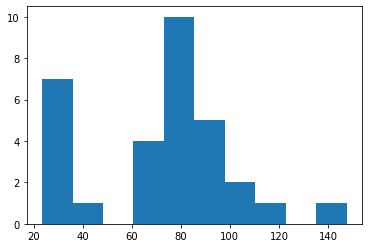

In [9]:
plt.hist(intensity_vector2[1:])

From such a histogram, we could conclude that objects with intensity above 50 are positive. 

## Selecting labels above a given intensity threshold
We next generate a new labels image with the nuclei having intensity > 50. Note, all the above steps for extracting the intensity vector are not necessary for this.

The following label image show the nuclei segmented in the Cy3 channel which have a high intensity in the eGFP channel.

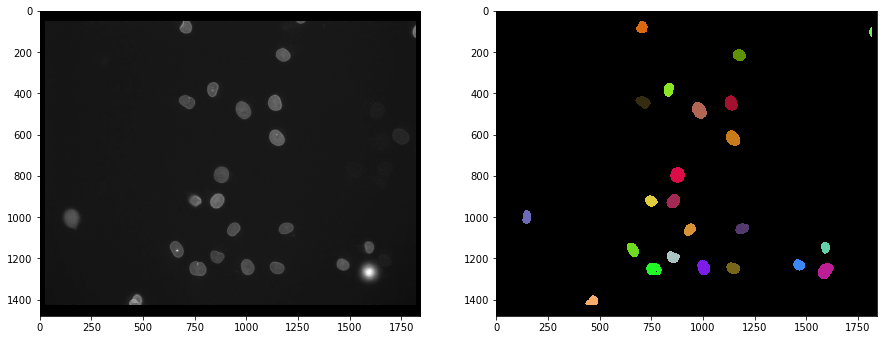

In [10]:
intensity_threshold = 50

nuclei_with_high_intensity_egfg = cle.exclude_labels_with_map_values_within_range(intensity_map, nuclei_cy3, maximum_value_range=intensity_threshold)
intensity_map = cle.mean_intensity_map(channel_egfp, nuclei_cy3)

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
cle.imshow(channel_egfp, plot=axs[0], color_map="gray")
cle.imshow(nuclei_with_high_intensity_egfg, plot=axs[1], labels=True)

And we can also count those by determining the maximum intensity in the label image:

In [11]:
number_of_double_positives = nuclei_with_high_intensity_egfg.max()
print("Number of Cy3 nuclei that also express eGFP", number_of_double_positives)

Number of Cy3 nuclei that also express eGFP 23.0


## References

Some of the functions we used might be uncommon. Hence, we can add their documentation for reference.

In [12]:
print(cle.voronoi_otsu_labeling.__doc__)

Labels objects directly from grey-value images.

    The two sigma parameters allow tuning the segmentation result. Under the hood,
    this filter applies two Gaussian blurs, spot detection, Otsu-thresholding [2] and Voronoi-labeling [3]. The
    thresholded binary image is flooded using the Voronoi tesselation approach starting from the found local maxima.
    
    Parameters
    ----------
    source : Image
        Input grey-value image
    label_image_destination : Image, optional
        Output image
    spot_sigma : float
        controls how close detected cells can be
    outline_sigma : float
        controls how precise segmented objects are outlined.
    
    Returns
    -------
    label_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.voronoi_otsu_labeling(source, label_image_destination, 10, 2)
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_voronoiOtsuLabeling
    .. [2]

In [13]:
print(cle.mean_intensity_map.__doc__)

Takes an image and a corresponding label map, determines the mean 
    intensity per label and replaces every label with the that number.
    
    This results in a parametric image expressing mean object intensity. 
    
    Parameters
    ----------
    input : Image
    label_map : Image
    destination : Image
    
    Returns
    -------
    destination
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_meanIntensityMap
    


In [14]:
print(cle.read_intensities_from_map.__doc__)

Takes a label image and a parametric image to read parametric values from the labels positions.
    The read intensity values are stored in a new vector.

    Note: This will only work if all labels have number of voxels == 1 or if all pixels in each label have the same value.

    Parameters
    ----------
    labels: Image
    map_image: Image
    values_destination: Image, optional
        1d vector with length == number of labels + 1

    Returns
    -------
    values_destination, Image:
        vector of intensity values with 0th element corresponding to background and subsequent entries corresponding to
        the intensity in the given labeled object
    


In [15]:
print(cle.statistics_of_background_and_labelled_pixels.__doc__)

Determines bounding box, area (in pixels/voxels), min, max and mean 
    intensity of background and labelled objects in a label map and corresponding
    pixels in the original image.
    
    Instead of a label map, you can also use a binary image as a binary image is a 
    label map with just one label.
    
    This method is executed on the CPU and not on the GPU/OpenCL device. 
    
    Parameters
    ----------
    input : Image
    labelmap : Image

    Returns
    -------
    Dictionary of measurements
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_statisticsOfBackgroundAndLabelledPixels
    


In [16]:
print(cle.exclude_labels_with_map_values_within_range.__doc__)

This operation removes labels from a labelmap and renumbers the
    remaining labels.

    Parameters
    ----------
    values_map : Image
    label_map_input : Image
    label_map_destination : Image
    minimum_value_range : Number
    maximum_value_range : Number

    Returns
    -------
    label_map_destination

    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_excludeLabelsWithValuesWithinRange
    
